In [1]:
%autoreload 2

from network_stats import *

In [8]:
def checkCompleted():
    conn = get_engine('networkData')
    res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
    completed = []
    for name in res:
        completed.append(name[0])

    return completed

def storeNetworkData(subreddits):
    completed = checkCompleted()
    for subreddit in subreddits:
        if subreddit not in completed:
            print('fetching', subreddit)
            df = fetchSubredditData(subreddit)
            saveSQL(df, table_name=subreddit, database_name='networkData')
        else:
            print(subreddit, 'already stored')

In [51]:
def getAuthorCounts(subreddit, data):
    authorCounts = data.subreddit.value_counts().sort_values(ascending=False)
    authorCounts.name = subreddit
    
    return authorCounts
    
def getCommentCounts(subreddit, data):
    commentCounts = data.groupby('subreddit')['authorCommentCount'].sum()
    commentCounts.name = subreddit
    
    return commentCounts

In [55]:
completed = checkCompleted()

counts = {'authors':{},'comments':{}}
for subreddit in completed:
    data = loadSQL(table_name=subreddit, database_name='networkData', index_col='index')
    authorCounts = getAuthorCounts(subreddit, data)
    commentCounts = getCommentCounts(subreddit, data)
    
    counts['authors'][subreddit] = authorCounts
    counts['comments'][subreddit] = commentCounts

In [56]:
weights = pd.DataFrame.from_dict(counts['authors'], orient='index')

In [59]:
weights = weights.fillna(0).T

In [63]:
weights = weights.sort_values('The_Donald', ascending=False)

In [75]:
c = weights.sum(axis=1)
regulars = c[c>1000].index

subset = weights.loc[regulars]
norm = subset/subset.sum()
norm.head()

,AskMen,Glitch_in_the_Matrix,HailCorporate,Michigan,Music,NoStupidQuestions,PalaceClothing,Physical_Removal,SaltLakeCity,SandersForPresident,...,canadaguns,cats,changemyview,curvy,cynicalbritofficial,financialindependence,indianpeoplefacebook,pittsburgh,tmobile,wiiu
The_Donald,0.005993,0.009029,0.013535,0.021277,0.004959,0.005395,0.005780,0.160405,0.010038,0.011517,...,0.021651,0.005098,0.008240,0.007519,0.002752,0.007833,0.008763,0.009905,0.005597,0.005571
AskReddit,0.147482,0.239278,0.098726,0.118541,0.093166,0.124475,0.161850,0.073699,0.151819,0.063470,...,0.142084,0.120175,0.103999,0.150376,0.122936,0.085856,0.114898,0.078828,0.053172,0.132312
politics,0.025177,0.025959,0.039809,0.087133,0.032233,0.024906,0.011561,0.052023,0.071518,0.090135,...,0.029770,0.019519,0.050863,0.048872,0.033028,0.032234,0.017527,0.045811,0.029540,0.034819
worldnews,0.030002,0.042889,0.059713,0.062817,0.042678,0.031773,0.063584,0.055636,0.061481,0.065348,...,0.069012,0.021122,0.051858,0.033835,0.069725,0.033740,0.043330,0.026826,0.022699,0.037604
news,0.028419,0.025959,0.050955,0.071935,0.037254,0.030410,0.017341,0.044075,0.053952,0.059089,...,0.037889,0.022141,0.046601,0.041353,0.030275,0.029824,0.033593,0.036731,0.025187,0.034819


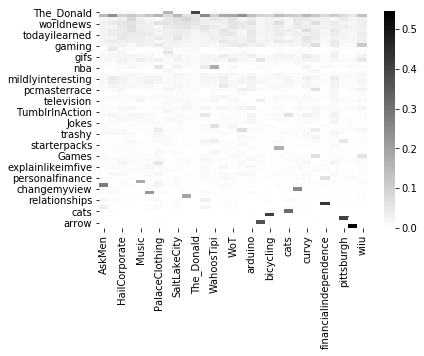

In [76]:
import seaborn as sns

sns.heatmap(norm, cmap='binary')

In [87]:
order = tuple(c.sort_values(ascending=False).index.copy())

Signature: weights.sort_index(axis=0, level=None, ascending=True, inplace=False, kind='quicksort', na_position='last', sort_remaining=True, by=None)
Source:   
    @Appender(_shared_docs['sort_index'] % _shared_doc_kwargs)
    def sort_index(self, axis=0, level=None, ascending=True, inplace=False,
                   kind='quicksort', na_position='last', sort_remaining=True,
                   by=None):

        # TODO: this can be combined with Series.sort_index impl as
        # almost identical

        inplace = validate_bool_kwarg(inplace, 'inplace')
        # 10726
        if by is not None:
            warnings.warn("by argument to sort_index is deprecated, "
                          "please use .sort_values(by=...)",
                          FutureWarning, stacklevel=2)
            if level is not None:
                raise ValueError("unable to simultaneously sort by and level")
            return self.sort_values(by, axis=axis, ascending=ascending,
                         